In [3]:
#Imports
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import copy
from keras import backend as K
#from tensorflow.keras.callbacks import TensorBoard
#from tensorflow.keras.layers import Dense, Reshape, Conv1D, LeakyReLU, Flatten

from utils.modelgenerator import *
from utils.modelhandler import *
from utils.datahandler import *
from keras.callbacks import History
import matplotlib.pyplot as plt
import csv

/Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack_git/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#Get data 
cwd = os.path.normpath(os.path.dirname(os.getcwd()))
df = pd.read_csv(cwd+'/data/2feature_engineering_data/df_with_final_features.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)

# Splits the DataFrame into smaller DataFrames for each user and selects specific columns of interest.
num_users = 6
df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

df_array[5]

,User6,temp,rhum,wspd,PC1,hour sin,hour cos,User6_lag_24hrs
Date,,,,,,,,
2012-07-08 00:00:00,0.509,9.8,85.0,0.0,-2.453691,0.000000,1.000000,0.836
2012-07-08 01:00:00,0.489,9.8,85.0,0.0,-2.453691,0.258819,0.965926,0.652
2012-07-08 02:00:00,0.573,9.8,85.0,0.0,-2.453691,0.500000,0.866025,0.673
2012-07-08 03:00:00,0.363,6.6,98.0,0.0,-2.946230,0.707107,0.707107,0.696
2012-07-08 04:00:00,0.595,6.6,98.0,0.0,-2.946230,0.866025,0.500000,0.695
...,...,...,...,...,...,...,...,...
2013-06-30 19:00:00,1.018,11.8,88.0,3.6,-1.044137,-0.965926,0.258819,1.291
2013-06-30 20:00:00,0.910,11.8,88.0,3.6,-1.044137,-0.866025,0.500000,0.883
2013-06-30 21:00:00,1.011,8.8,99.0,1.8,-2.332378,-0.707107,0.707107,1.499


In [3]:
#Train, Validation and Test datasets
sequence_length = 25
batch_size = 16
num_features = df_array[0].shape[1]

dh = Datahandler()

# Initialize Data Split Dictionaries: Sets up dictionaries to store train, validation, and test data for each user.
X_train, y_train, X_val, y_val, X_test, y_test = {}, {}, {}, {}, {}, {}

#Create Train, Validation and Test datasets
for idx, df in enumerate(df_array):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Min max sclaing 
    # Min-Max Scaling: Scales the data within each set (train, validation, test) to a specific range (typically between 0 and 1) to ensure uniformity and improve model convergence.
    train_df = dh.min_max_scaling(train_df)
    val_df = dh.min_max_scaling(val_df)
    test_df = dh.min_max_scaling(test_df)

    # Sequencing
    # Sequence Creation: Converts the data into sequences of a fixed length to feed into the model. This step is crucial for sequence prediction tasks, like time series forecasting.
    train_sequences = dh.create_sequences(train_df, sequence_length)
    val_sequences = dh.create_sequences(val_df, sequence_length)
    test_sequences = dh.create_sequences(test_df, sequence_length)

    #Split into feature and label
    X_train[f'user{idx+1}'], y_train[f'user{idx+1}'] = dh.prepare_data(train_sequences, batch_size)
    X_val[f'user{idx+1}'], y_val[f'user{idx+1}'] = dh.prepare_data(val_sequences, batch_size)
    X_test[f'user{idx+1}'], y_test[f'user{idx+1}'] = dh.prepare_data(test_sequences, batch_size)


In [4]:
#General Hyperparameters
# #All models
horizon = 1
max_epochs = 100
m1 = ModelGenerator()
mh = Modelhandler()

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()
#tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)


#model_checkpoint = ModelCheckpoint('models/best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks=[early_stopping, timing_callback, custom_callback] #model_checkpoint

In [5]:
def fed_avg_weights(weight_list, clip_threshold=None):
    avg_grad = list()

    for grad_list_tuple in zip(*weight_list):
        layer_mean = tf.math.reduce_mean(grad_list_tuple, axis=0)

        if clip_threshold is not None:
            layer_mean = tf.clip_by_value(layer_mean, -clip_threshold, clip_threshold)

        avg_grad.append(layer_mean)

    return avg_grad

In [6]:
num_clusters = 6
y = np.loadtxt(f'../evaluations/clusters_KMeansNew{num_clusters}_dtw.csv', delimiter=',').astype(int)

cluster_users = {i: [] for i in range(num_clusters)}

# Iterate through each cluster
for cluster_number in range(num_clusters):
    users_in_cluster = np.where(y == cluster_number)[0] +1
    cluster_users[cluster_number] = users_in_cluster
cluster_users

{0: array([ 2,  7, 11, 23, 24, 30]),
 1: array([ 5, 10, 12, 15, 16, 17, 21, 22, 25, 26, 28]),
 2: array([ 3,  4, 19, 27, 29]),
 3: array([ 9, 14]),
 4: array([ 6,  8, 13, 18, 20]),
 5: array([1])}

In [9]:
architecture = "BiLSTM_L1_U8"

lstm_layers = 1
lstm_units = 8

In [20]:
# Create global models for each cluser (6)
for cluster in range(num_clusters):
#Build and save global model
    global_model = m1.build_bilstm_model(X_train[f'user{1}'], horizon, num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
    global_model.save(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_{cluster}/{architecture}/FederatedRound{0}")

INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_0/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_0/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_1/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_1/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_2/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_2/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_3/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_3/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_4/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_4/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_5/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_5/BiLSTM_L1_U8/FederatedRound0/assets


In [27]:
federated_rounds = 3
for federated_round  in range(federated_rounds):
    print("Started Federated training round ----------", federated_round+1, f"/ {federated_rounds}")

    for cluster_number, users_in_cluster in cluster_users.items():
        print(f"Cluster {cluster_number}:")

        #Get global models weights
        global_model = keras.models.load_model(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
        global_model_weights = global_model.get_weights()

        #initial list for local model weights
        local_model_weight_list = list()


        #for idx, user in enumerate(df_array): 
        for user_index in users_in_cluster:
            user_df = df_array[user_index-1]  # Get the user's DataFrame from the array
            print(f"User {user_index}") 
                      
            #build and compile local model X_train, batch_size, horizon, dense_units,  expert_units, num_experts, m1
            local_model = m1.build_bilstm_model(X_train[f'user{user_index}'], horizon, num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
            local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006), metrics=metrics)

            #set local model weight to the weight of the global model
            local_model.set_weights(global_model_weights)
            
            #Fit local model to local data
            history, user_results = mh.compile_fit_evaluate_model(
                model=local_model, 
                loss=loss, 
                metrics=metrics, 
                X_train=X_train[f'user{user_index}'],
                y_train = y_train[f'user{user_index}'], 
                max_epochs = max_epochs, 
                batch_size=batch_size, 
                X_val=X_val[f'user{user_index}'], 
                y_val=y_val[f'user{user_index}'], 
                X_test=X_test[f'user{user_index}'], 
                y_test=y_test[f'user{user_index}'], 
                callbacks=callbacks, 
                user=f'user{user_index}', 
                hyper=architecture,
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
            )
            #add model weights to list        
            local_model_weights = local_model.get_weights()
            local_model_weight_list.append(local_model_weights)
        
            #clear session to free memory after each communication round
            K.clear_session()
        
        #to get the average over all the local model, we simply take the sum of the scaled weights

        average_weights = fed_avg_weights(local_model_weight_list)
        #update global model 
        global_model.set_weights(average_weights)
        #Save global models
        global_model.save(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round+1}")
        print("Saved Global models")


Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 7
User 11
User 23
User 24
User 30


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_0/BiLSTM_L1_U8/FederatedRound1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_0/BiLSTM_L1_U8/FederatedRound1/assets


Saved Global models
Cluster 1:
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_1/BiLSTM_L1_U8/FederatedRound1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_1/BiLSTM_L1_U8/FederatedRound1/assets


Saved Global models
Cluster 2:
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_2/BiLSTM_L1_U8/FederatedRound1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_2/BiLSTM_L1_U8/FederatedRound1/assets


Saved Global models
Cluster 3:
User 9
User 14


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_3/BiLSTM_L1_U8/FederatedRound1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_3/BiLSTM_L1_U8/FederatedRound1/assets


Saved Global models
Cluster 4:
User 6
User 8
User 13
User 18
User 20


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_4/BiLSTM_L1_U8/FederatedRound1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_4/BiLSTM_L1_U8/FederatedRound1/assets


Saved Global models
Cluster 5:
User 1


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_5/BiLSTM_L1_U8/FederatedRound1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_5/BiLSTM_L1_U8/FederatedRound1/assets


Saved Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 7
User 11
User 23
User 24
User 30


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_0/BiLSTM_L1_U8/FederatedRound2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_0/BiLSTM_L1_U8/FederatedRound2/assets


Saved Global models
Cluster 1:
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_1/BiLSTM_L1_U8/FederatedRound2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_1/BiLSTM_L1_U8/FederatedRound2/assets


Saved Global models
Cluster 2:
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_2/BiLSTM_L1_U8/FederatedRound2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_2/BiLSTM_L1_U8/FederatedRound2/assets


Saved Global models
Cluster 3:
User 9
User 14


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_3/BiLSTM_L1_U8/FederatedRound2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_3/BiLSTM_L1_U8/FederatedRound2/assets


Saved Global models
Cluster 4:
User 6
User 8
User 13
User 18
User 20


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_4/BiLSTM_L1_U8/FederatedRound2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_4/BiLSTM_L1_U8/FederatedRound2/assets


Saved Global models
Cluster 5:
User 1


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_5/BiLSTM_L1_U8/FederatedRound2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_5/BiLSTM_L1_U8/FederatedRound2/assets


Saved Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 7
User 11
User 23
User 24
User 30


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_0/BiLSTM_L1_U8/FederatedRound3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_0/BiLSTM_L1_U8/FederatedRound3/assets


Saved Global models
Cluster 1:
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_1/BiLSTM_L1_U8/FederatedRound3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_1/BiLSTM_L1_U8/FederatedRound3/assets


Saved Global models
Cluster 2:
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_2/BiLSTM_L1_U8/FederatedRound3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_2/BiLSTM_L1_U8/FederatedRound3/assets


Saved Global models
Cluster 3:
User 9
User 14


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_3/BiLSTM_L1_U8/FederatedRound3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_3/BiLSTM_L1_U8/FederatedRound3/assets


Saved Global models
Cluster 4:
User 6
User 8
User 13
User 18
User 20


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_4/BiLSTM_L1_U8/FederatedRound3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_4/BiLSTM_L1_U8/FederatedRound3/assets


Saved Global models
Cluster 5:
User 1


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_5/BiLSTM_L1_U8/FederatedRound3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_5/BiLSTM_L1_U8/FederatedRound3/assets


Saved Global models


In [28]:
#Evaluation
all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

for cluster_number, users_in_cluster in cluster_users.items():
    print(f"Cluster {cluster_number}:")

    #Get global models weights
    global_model = tf.keras.models.load_model(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}", compile=False)

    #for idx, user in enumerate(df_array): 
    for user_index in users_in_cluster:
        print("User: ", user_index)
        for round in range(3):
            global_model = tf.keras.models.load_model(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}", compile=False)
            local_model = m1.build_bilstm_model(X_train[f'user{user_index}'], horizon, num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
            local_model.set_weights(global_model.get_weights())
            
            history, user_results = mh.compile_fit_evaluate_model(
                model=local_model, 
                loss=loss, 
                metrics=metrics, 
                X_train=X_train[f'user{user_index}'],
                y_train = y_train[f'user{user_index}'], 
                max_epochs = 1, 
                batch_size=batch_size, 
                X_val=X_val[f'user{user_index}'], 
                y_val=y_val[f'user{user_index}'], 
                X_test=X_test[f'user{user_index}'], 
                y_test=y_test[f'user{user_index}'], 
                callbacks=callbacks, 
                user=f'user{user_index}', 
                hyper=architecture,
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006)
            )
        
            # Add the 'architecture' column from dense_user_results to dense_results
            all_results = pd.merge(all_results, user_results, how='outer')  

results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse','mse_std', 'rmse','rmse_std','mape','mape_std','mae','mae_std'])
for idx in range(len(df_array)):

    new_row = {
        'architecture': architecture,
        'train_time': all_results[all_results["user"]==f"user{idx+1}"]["train_time"].mean(), 
        'avg_time_epoch' : all_results[all_results["user"]==f"user{idx+1}"]["avg_time_epoch"].mean(),
        'mse': all_results[all_results["user"]==f"user{idx+1}"]["mse"].mean(),
        'mse_std' : all_results[all_results["user"]==f"user{idx+1}"]["mse"].std(),
        'rmse': all_results[all_results["user"]==f"user{idx+1}"]["rmse"].mean(),
        'rmse_std' : all_results[all_results["user"]==f"user{idx+1}"]["rmse"].std(),
        'mape': all_results[all_results["user"]==f"user{idx+1}"]["mape"].mean(),
        'mape_std' : all_results[all_results["user"]==f"user{idx+1}"]["mape"].std(),
        'mae': all_results[all_results["user"]==f"user{idx+1}"]["mae"].mean(),
        'mae_std' : all_results[all_results["user"]==f"user{idx+1}"]["mae"].std(),
    }
    results.loc[len(results)] = new_row

# Get the parent directory of the current working directory
parent_folder = os.path.dirname(os.getcwd())
folder_name = 'results_without_noise'
file_name = f'results_{max_epochs}_epochs_30_users.csv'
parent_path = os.path.join(parent_folder, folder_name)

# Construct the path for the CSV file inside the parent folder
file_path = os.path.join(parent_path, file_name)

# Save Results to CSV File (overwriting previous results)
results.to_csv(file_path, index=False)

# Assuming cluster_users is a dictionary with cluster numbers as keys and lists of user indices as values
cluster_number = 1  # Change this to the cluster number you are interested in
users_in_cluster = cluster_users[cluster_number]

# Adjust the user indices to match the 0-based index
adjusted_users_in_cluster = [user_index - 1 for user_index in users_in_cluster]

# Filter the results DataFrame to include only the users in the specified cluster
cluster_results = results[results.index.isin(adjusted_users_in_cluster)]

#Calculate the sum of the MSE values for the users in the specified cluster
mse_sum = cluster_results['mse'].sum()
print(f"Sum of 'mse' column for users in cluster {cluster_number}:", mse_sum)

results

Cluster 0:
User:  2
User:  7
User:  11
User:  23
User:  24
User:  30
Cluster 1:
User:  5
User:  10
User:  12
User:  15
User:  16
User:  17
User:  21
User:  22
User:  25
User:  26
User:  28
Cluster 2:
User:  3
User:  4
User:  19
User:  27
User:  29
Cluster 3:
User:  9
User:  14
Cluster 4:
User:  6
User:  8
User:  13
User:  18
User:  20
Cluster 5:
User:  1
Sum of 'mse' column for users in cluster 1: 0.18490511924028394


,architecture,train_time,avg_time_epoch,mse,mse_std,rmse,rmse_std,mape,mape_std,mae,mae_std
0,BiLSTM_L1_U8,2.336664,2.262549,0.034158,0.000529,0.184816,0.001434,6.521169e+04,12871.162186,0.117455,0.001566
1,BiLSTM_L1_U8,2.643460,2.551868,0.018784,0.000319,0.137051,0.001168,2.638723e+05,13254.505959,0.082412,0.001954
2,BiLSTM_L1_U8,2.289543,2.217973,0.019315,0.000102,0.138977,0.000368,5.889452e+04,4124.411425,0.075038,0.002642
3,BiLSTM_L1_U8,2.370817,2.281711,0.022690,0.000302,0.150631,0.001003,1.624299e+05,5993.285261,0.063257,0.000561
4,BiLSTM_L1_U8,2.193879,2.122511,0.014431,0.000339,0.120124,0.001408,6.943335e+04,827.230953,0.079538,0.001617
5,BiLSTM_L1_U8,2.338832,2.262759,0.020390,0.000550,0.142784,0.001935,9.262135e+04,5058.828401,0.099883,0.001278
6,BiLSTM_L1_U8,2.774879,2.692572,0.018514,0.000956,0.136036,0.003523,9.537243e+04,13908.992476,0.080182,0.004442
7,BiLSTM_L1_U8,2.346678,2.269533,0.032242,0.003055,0.179428,0.008430,2.783904e+04,6028.925192,0.113594,0.005164
8,BiLSTM_L1_U8,2.307940,2.229573,0.029859,0.001295,0.172769,0.003765,8.831167e+01,8.836617,0.107181,0.004238
9,BiLSTM_L1_U8,2.210133,2.137345,0.015206,0.000295,0.123309,0.001200,2.201784e+06,14754.091899,0.074275,0.000992


52/52 [==============================] - 0s 950us/step


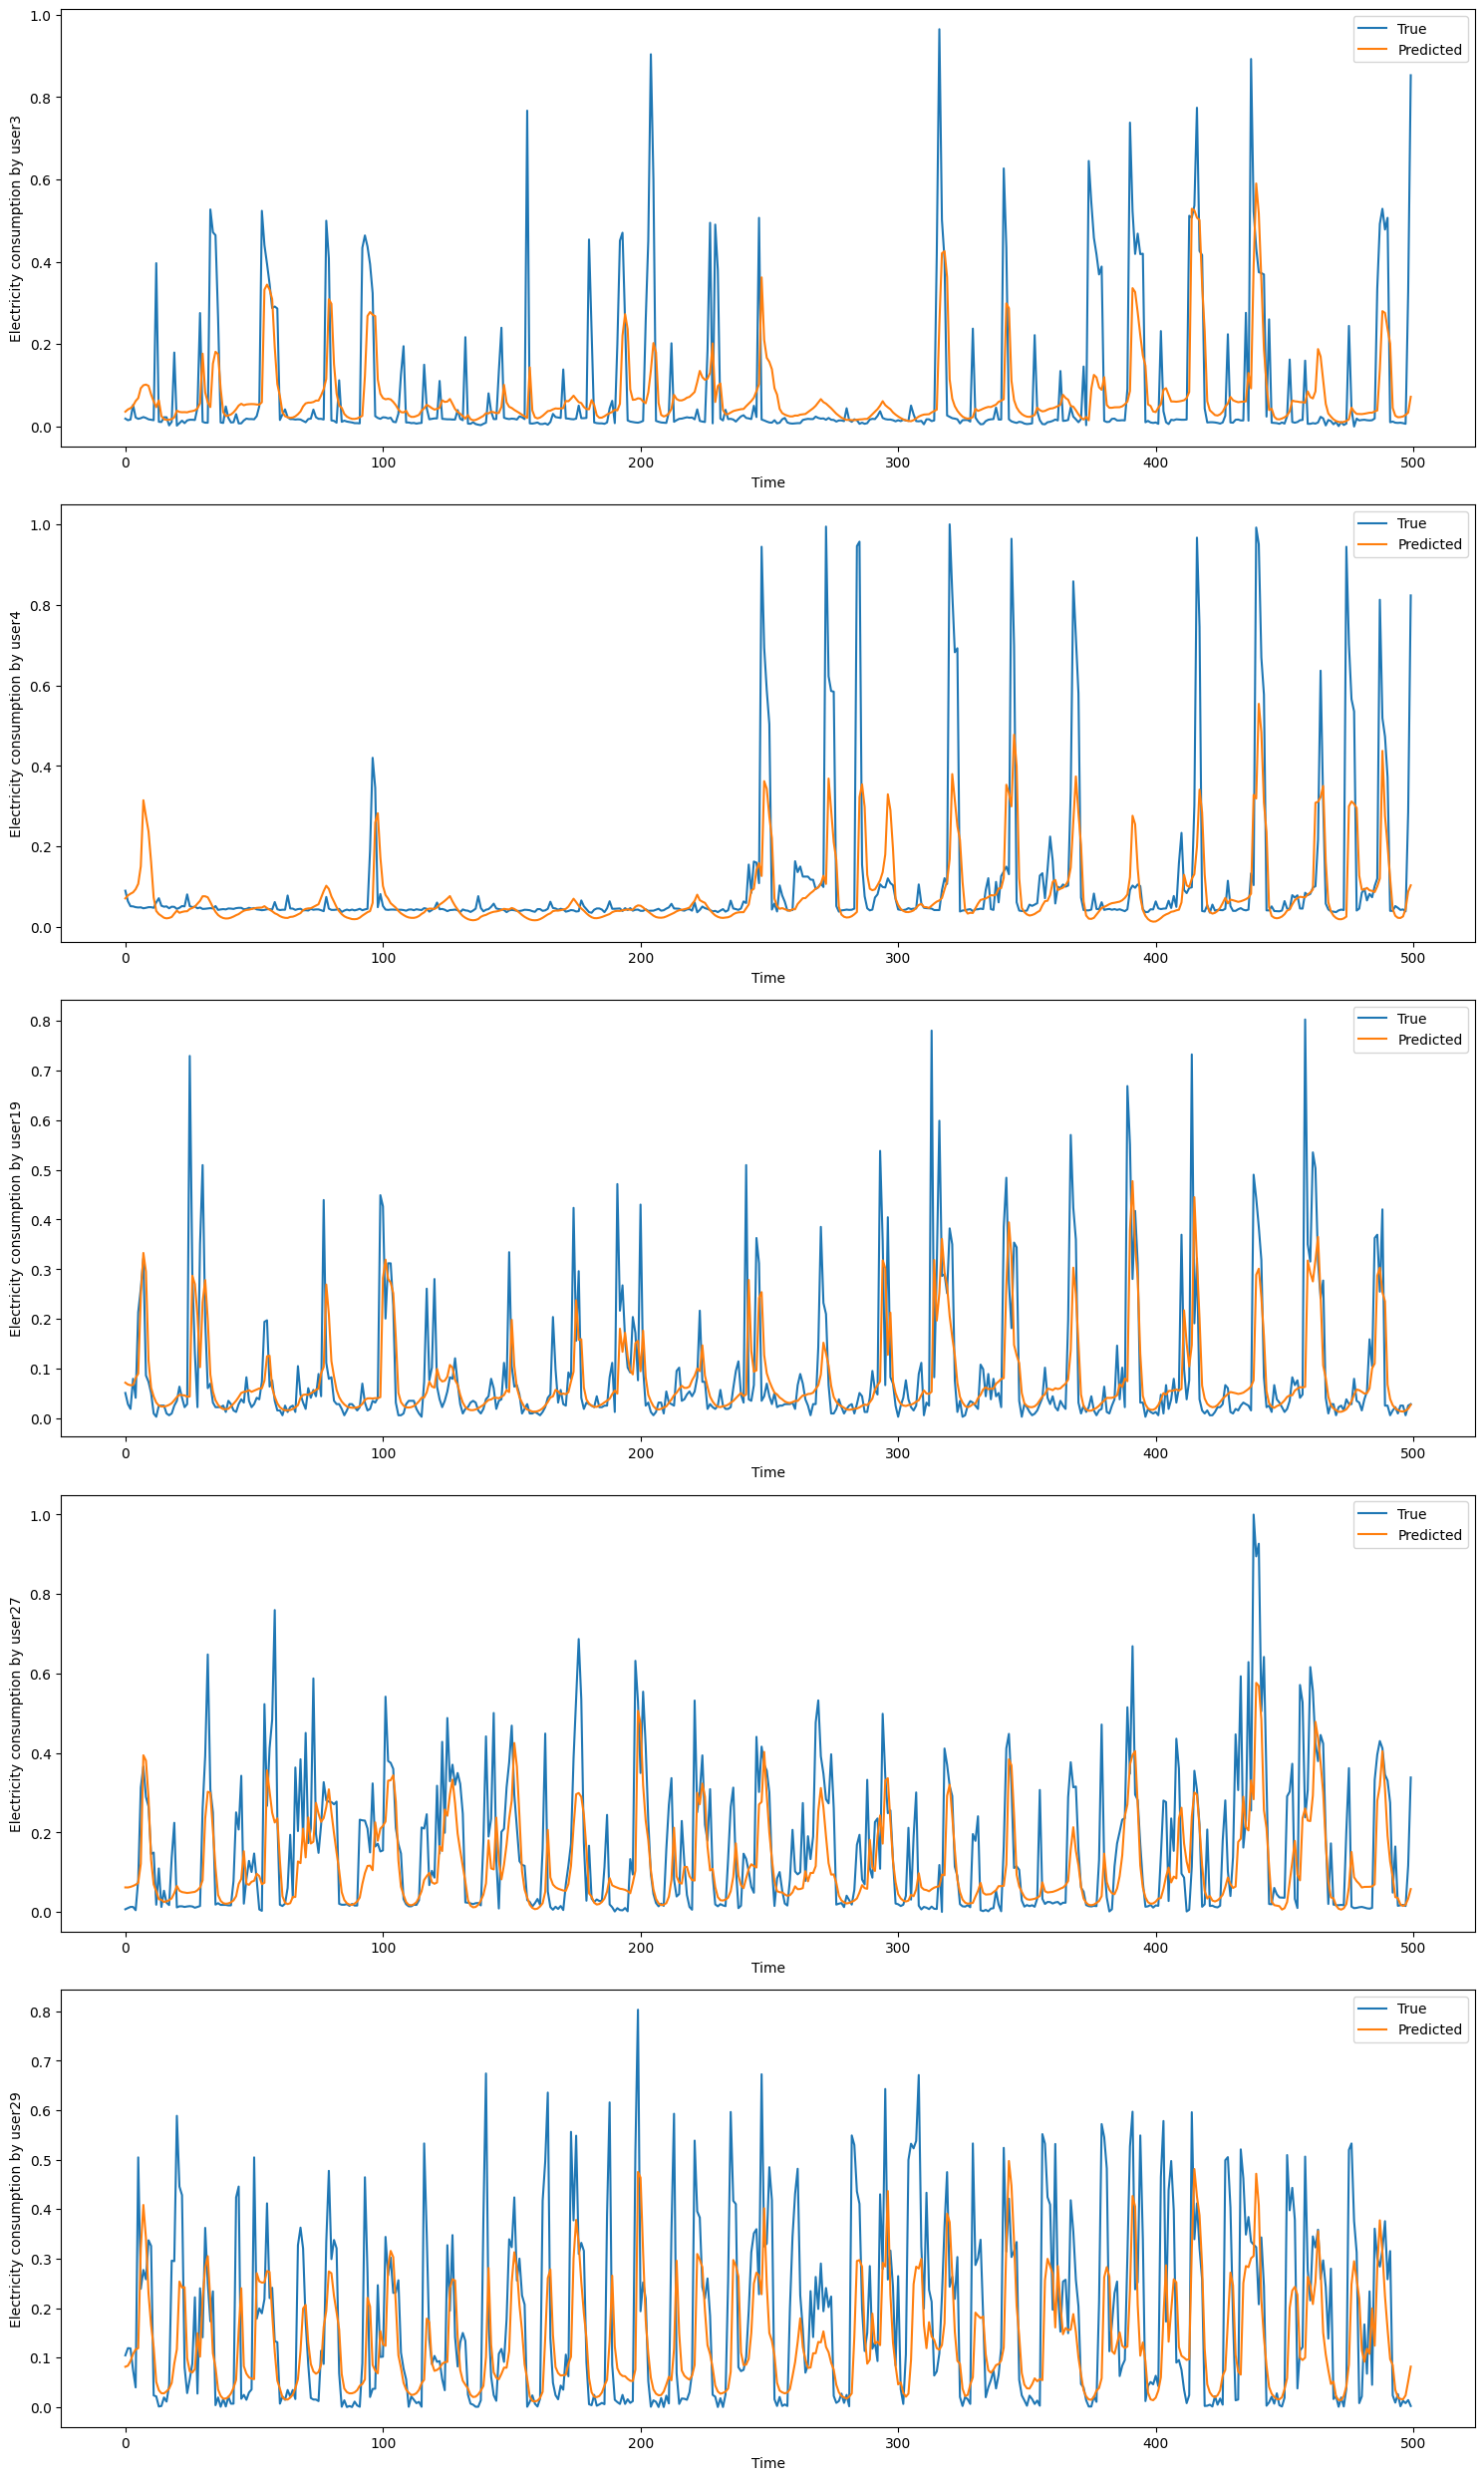

In [33]:
global_model = keras.models.load_model(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
global_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006), metrics=metrics)

# List of users for whom you want to plot predictions
users = ['user3', 'user4', 'user19', 'user27', 'user29']

# Define the number of rows and columns for subplots
num_rows = len(users)
num_cols = 1  # Since you want each plot to be in a separate row

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Iterate over users and plot predictions
for i, user in enumerate(users):
    pred_global_model = global_model.predict(X_test[user], batch_size=batch_size)

    start = 200
    stop = start + 500
    ax = axes[i] if num_rows > 1 else axes  # Use the appropriate axis for plotting

    ax.plot(y_test[user][start:stop], label='True')
    ax.plot(pred_global_model[start:stop], label='Predicted')
    ax.set_xlabel('Time')
    ax.set_ylabel(f'Electricity consumption by {user}')
    ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Data Poisoning Attack on the cluster containing 5 users

In [29]:
# Define your desired noise scales
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 12]

# Function to generate adversarial data using exponential distribution
def generate_adversarial_data(original_data, noise_scale):
    adversarial_data = np.random.laplace(0, noise_scale, original_data.shape)
    return adversarial_data

# Loop over different noise scales
for noise_scale in noise_scales:
    print(f"Testing noise scale: {noise_scale}")
    
    # Generate adversarial data for user4
    user4_adversarial_data = generate_adversarial_data(X_train['user4'], noise_scale)

    # Inject adversarial data into the training dataset for user4
    X_train_poisoned = copy.deepcopy(X_train)
    X_train_poisoned['user4'] = X_train['user4'] + user4_adversarial_data

    federated_rounds = 3
    for federated_round in range(federated_rounds):
        print("Started Federated training round ----------", federated_round + 1, f"/ {federated_rounds}")

        for cluster_number, users_in_cluster in cluster_users.items():
            if 4 not in users_in_cluster:
                print(f"Skipping Cluster {cluster_number} as it does not contain user4")
                continue

            print(f"Cluster {cluster_number} contains user4")

            # Get global models weights
            poisoned_global_model = keras.models.load_model(
                cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
            poisoned_global_model_weights = poisoned_global_model.get_weights()

            # Initial list for local model weights
            poisoned_local_model_weight_list = list()

            for user_index in users_in_cluster:
                user_df = df_array[user_index - 1]  # Get the user's DataFrame from the array
                print(f"User {user_index}")

                # Build and compile local model
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                              num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)

                # Set local model weight to the weight of the global model
                poisoned_local_model.set_weights(poisoned_global_model_weights)

                # Fit local model to local data
                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=max_epochs,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                )

                # Add model weights to list
                poisoned_local_model_weights = poisoned_local_model.get_weights()
                poisoned_local_model_weight_list.append(poisoned_local_model_weights)

                # Clear session to free memory after each communication round
                K.clear_session()

            # To get the average over all the local models, we simply take the sum of the scaled weights
            average_weights = fed_avg_weights(poisoned_local_model_weight_list)
            # Update poisoned global model
            poisoned_global_model.set_weights(average_weights)
            # Save poisoned global models
            poisoned_global_model.save(cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round + 1}/NoiseScale_{noise_scale}")
            print("Saved Poisoned Global models")


Testing noise scale: 0.2
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Testing noise scale: 0.3
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Testing noise scale: 0.5
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Testing noise scale: 0.8
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Testing noise scale: 1
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Testing noise scale: 12
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User 3
User 4
User 19
User 27
User 29


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_2/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


Saved Poisoned Global models
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4


In [31]:
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 12]  # Define your desired noise scales
# Initialize the dictionary to store MSE values for each user and noise scale
mse_results_per_user_separate = {}

# Evaluation
for noise_scale in noise_scales:
    print(f"Evalution noise scale: {noise_scale}")

    all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

    for cluster_number, users_in_cluster in cluster_users.items():
        if 4 not in users_in_cluster:
            print(f"Skipping Cluster {cluster_number} as it does not contain user4")
            continue

        print(f"Cluster {cluster_number} contains user4")

        # Get global models weights
        poisoned_global_model = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)

        for user_index in users_in_cluster:
            print("User: ", user_index)
            for round in range(3):
                poisoned_global_model = tf.keras.models.load_model(
                    cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user4_laplace/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                             num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)
                poisoned_local_model.set_weights(poisoned_global_model.get_weights())

                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=1,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006)
                )

                # Add the 'architecture' column from dense_user_results to dense_results
                all_results = pd.merge(all_results, user_results, how='outer')

    results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse', 'mse_std', 'rmse', 'rmse_std', 'mape', 'mape_std', 'mae', 'mae_std'])
    for idx in range(len(df_array)):
        new_row = {
            'architecture': architecture,
            'train_time': all_results[all_results["user"] == f"user{idx + 1}"]["train_time"].mean(),
            'avg_time_epoch': all_results[all_results["user"] == f"user{idx + 1}"]["avg_time_epoch"].mean(),
            'mse': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].mean(),
            'mse_std': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].std(),
            'rmse': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].mean(),
            'rmse_std': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].std(),
            'mape': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].mean(),
            'mape_std': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].std(),
            'mae': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].mean(),
            'mae_std': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].std(),
        }
        results.loc[len(results)] = new_row

    # Get the parent directory of the current working directory
    parent_folder = os.path.dirname(os.getcwd())
    folder_name = 'results_with_noise'
    file_name = f'epochs_{max_epochs}_noise_scale_{noise_scale}_user4_laplace.csv'
    parent_path = os.path.join(parent_folder, folder_name)

    # Construct the path for the CSV file inside the parent folder
    file_path = os.path.join(parent_path, file_name)

    # Save Results to CSV File (overwriting previous results)
    results.to_csv(file_path, index=False)

    # Assuming cluster_users is a dictionary with cluster numbers as keys and lists of user indices as values
    cluster_number = 2  # Change this to the cluster number you are interested in
    users_in_cluster = cluster_users[cluster_number]

    # Adjust the user indices to match the 0-based index
    adjusted_users_in_cluster = [user_index - 1 for user_index in users_in_cluster]

    # Filter the results DataFrame to include only the users in the specified cluster
    cluster_results = results[results.index.isin(adjusted_users_in_cluster)]

    # Calculate the sum of the MSE values for each user separately and add to the dictionary
    for user_index in users_in_cluster:
        user_key = f"user{user_index}"
        if user_key not in mse_results_per_user_separate:
            mse_results_per_user_separate[user_key] = {}
        user_mse_sum = cluster_results[cluster_results.index == user_index - 1]['mse'].sum()
        mse_results_per_user_separate[user_key][noise_scale] = user_mse_sum

# Save the combined results to a CSV file
folder_name = 'seperate_user_results'
file_name = 'combined_mse_results_user4_laplace.csv'
parent_path = os.path.join(parent_folder, folder_name)

# Construct the path for the CSV file inside the parent folder
file_path = os.path.join(parent_path, file_name)

# Open the CSV file in write mode
with open(file_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write header row
    header = ['User'] + [f'NoiseScale_{ns}' for ns in noise_scales]
    writer.writerow(header)
    
    # Write each dictionary item as a row
    for user, noise_scale_dict in mse_results_per_user_separate.items():
        row = [user] + [noise_scale_dict.get(ns, None) for ns in noise_scales]
        writer.writerow(row)

print("MSE sums for each user in cluster:", mse_results_per_user_separate)


Evalution noise scale: 0.2
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User:  3
User:  4
User:  19
User:  27
User:  29
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Evalution noise scale: 0.3
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User:  3
User:  4
User:  19
User:  27
User:  29
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it does not contain user4
Evalution noise scale: 0.5
Skipping Cluster 0 as it does not contain user4
Skipping Cluster 1 as it does not contain user4
Cluster 2 contains user4
User:  3
User:  4
User:  19
User:  27
User:  29
Skipping Cluster 3 as it does not contain user4
Skipping Cluster 4 as it does not contain user4
Skipping Cluster 5 as it doe

In [8]:
base_dir = os.path.dirname(cwd)
csv_path = os.path.join(base_dir, 'seperate_user_results', 'combined_mse_results_user4_laplace.csv')
csv_path

'/Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack_git/seperate_user_results/combined_mse_results_user4_laplace.csv'

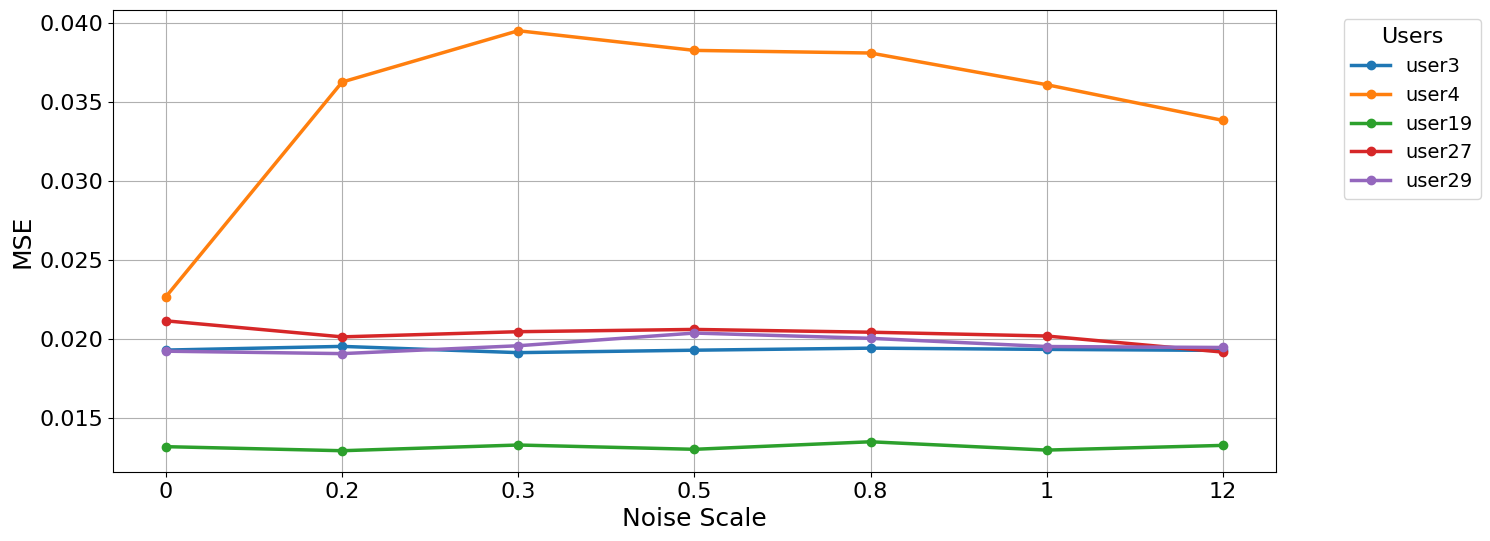

In [19]:
# Load the data
base_dir = os.path.dirname(cwd)
csv_path = os.path.join(base_dir, 'seperate_user_results', 'combined_mse_results_user4_laplace.csv')
df_base = pd.read_csv(csv_path)

# Get the list of users and noise scales from the columns
users = df_base['User'].values
noise_scales = ['0', '0.2', '0.3', '0.5', '0.8', '1', '12']

# Define the base values for each user
base_values = {
    'user3': 0.01931,
    'user4': 0.02269,
    'user19': 0.01320,
    'user27': 0.02116,
    'user29': 0.01924
}

# Initialize a dictionary to store MSE values for each user across noise scales
mse_per_user = {user: [] for user in users}

# Populate the dictionary with base values and MSE values for each noise scale
for user in users:
    base_value = base_values.get(user, 0)  # Get the base value for the user
    mse_values = df_base[df_base['User'] == user].values[0][1:].tolist()
    mse_per_user[user] = [base_value] + mse_values  # Prepend the base value

plt.figure(figsize=(15, 6))

# Plot lines for each user
for user in users:
    plt.plot(noise_scales, mse_per_user[user], label=f'{user}', linestyle='solid', marker='o', linewidth=2.5)

# Increase the font size for x and y axis labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Noise Scale', fontsize=18)
plt.ylabel('MSE', fontsize=18)

plt.grid(True)
plt.legend(title='Users', fontsize=14, title_fontsize=16, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()


### Data Poisoning Attack on the cluster containing 11 users

In [12]:
# Define your desired noise scales
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 12]

# Function to generate adversarial data using exponential distribution
def generate_adversarial_data(original_data, noise_scale):
    adversarial_data = np.random.laplace(0, noise_scale, original_data.shape)
    return adversarial_data

# Loop over different noise scales
for noise_scale in noise_scales:
    print(f"Testing noise scale: {noise_scale}")
    
    # Generate adversarial data for user15
    user15_adversarial_data = generate_adversarial_data(X_train['user15'], noise_scale)

    # Inject adversarial data into the training dataset for user15
    X_train_poisoned = copy.deepcopy(X_train)
    X_train_poisoned['user15'] = X_train['user15'] + user15_adversarial_data

    federated_rounds = 3
    for federated_round in range(federated_rounds):
        print("Started Federated training round ----------", federated_round + 1, f"/ {federated_rounds}")

        for cluster_number, users_in_cluster in cluster_users.items():
            if 15 not in users_in_cluster:
                print(f"Skipping Cluster {cluster_number} as it does not contain user15")
                continue

            print(f"Cluster {cluster_number} contains user15")

            # Get global models weights
            poisoned_global_model = keras.models.load_model(
                cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_30_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
            poisoned_global_model_weights = poisoned_global_model.get_weights()

            # Initial list for local model weights
            poisoned_local_model_weight_list = list()

            for user_index in users_in_cluster:
                user_df = df_array[user_index - 1]  # Get the user's DataFrame from the array
                print(f"User {user_index}")

                # Build and compile local model
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                              num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)

                # Set local model weight to the weight of the global model
                poisoned_local_model.set_weights(poisoned_global_model_weights)

                # Fit local model to local data
                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=max_epochs,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                )

                # Add model weights to list
                poisoned_local_model_weights = poisoned_local_model.get_weights()
                poisoned_local_model_weight_list.append(poisoned_local_model_weights)

                # Clear session to free memory after each communication round
                K.clear_session()

            # To get the average over all the local models, we simply take the sum of the scaled weights
            average_weights = fed_avg_weights(poisoned_local_model_weight_list)
            # Update poisoned global model
            poisoned_global_model.set_weights(average_weights)
            # Save poisoned global models
            poisoned_global_model.save(cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round + 1}/NoiseScale_{noise_scale}")
            print("Saved Poisoned Global models")


Testing noise scale: 0.2
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Testing noise scale: 0.3
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Testing noise scale: 0.5
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Testing noise scale: 0.8
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Testing noise scale: 1
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Testing noise scale: 12
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User 5
User 10
User 12
User 15
User 16
User 17
User 21
User 22
User 25
User 26
User 28


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


Saved Poisoned Global models
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15


In [13]:
federated_rounds = 3
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 12]  # Define your desired noise scales
# Initialize the dictionary to store MSE values for each user and noise scale
mse_results_per_user_separate = {}

# Evaluation
for noise_scale in noise_scales:
    print(f"Evalution noise scale: {noise_scale}")

    all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

    for cluster_number, users_in_cluster in cluster_users.items():
        if 15 not in users_in_cluster:
            print(f"Skipping Cluster {cluster_number} as it does not contain user15")
            continue

        print(f"Cluster {cluster_number} contains user15")

        # Get global models weights
        poisoned_global_model = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)

        for user_index in users_in_cluster:
            print("User: ", user_index)
            for round in range(3):
                poisoned_global_model = tf.keras.models.load_model(
                    cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user15_laplace/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                             num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)
                poisoned_local_model.set_weights(poisoned_global_model.get_weights())

                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=1,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006)
                )

                # Add the 'architecture' column from dense_user_results to dense_results
                all_results = pd.merge(all_results, user_results, how='outer')

    results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse', 'mse_std', 'rmse', 'rmse_std', 'mape', 'mape_std', 'mae', 'mae_std'])
    for idx in range(len(df_array)):
        new_row = {
            'architecture': architecture,
            'train_time': all_results[all_results["user"] == f"user{idx + 1}"]["train_time"].mean(),
            'avg_time_epoch': all_results[all_results["user"] == f"user{idx + 1}"]["avg_time_epoch"].mean(),
            'mse': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].mean(),
            'mse_std': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].std(),
            'rmse': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].mean(),
            'rmse_std': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].std(),
            'mape': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].mean(),
            'mape_std': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].std(),
            'mae': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].mean(),
            'mae_std': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].std(),
        }
        results.loc[len(results)] = new_row

    # Get the parent directory of the current working directory
    parent_folder = os.path.dirname(os.getcwd())
    folder_name = 'results_with_noise'
    file_name = f'epochs_{max_epochs}_noise_scale_{noise_scale}_user15_laplace.csv'
    parent_path = os.path.join(parent_folder, folder_name)

    # Construct the path for the CSV file inside the parent folder
    file_path = os.path.join(parent_path, file_name)

    # Save Results to CSV File (overwriting previous results)
    results.to_csv(file_path, index=False)

    # Assuming cluster_users is a dictionary with cluster numbers as keys and lists of user indices as values
    cluster_number = 1  # Change this to the cluster number you are interested in
    users_in_cluster = cluster_users[cluster_number]

    # Adjust the user indices to match the 0-based index
    adjusted_users_in_cluster = [user_index - 1 for user_index in users_in_cluster]

    # Filter the results DataFrame to include only the users in the specified cluster
    cluster_results = results[results.index.isin(adjusted_users_in_cluster)]

    # Calculate the sum of the MSE values for each user separately and add to the dictionary
    for user_index in users_in_cluster:
        user_key = f"user{user_index}"
        if user_key not in mse_results_per_user_separate:
            mse_results_per_user_separate[user_key] = {}
        user_mse_sum = cluster_results[cluster_results.index == user_index - 1]['mse'].sum()
        mse_results_per_user_separate[user_key][noise_scale] = user_mse_sum

# Save the combined results to a CSV file
folder_name = 'seperate_user_results'
file_name = 'combined_mse_results_user15_laplace.csv'
parent_path = os.path.join(parent_folder, folder_name)

# Construct the path for the CSV file inside the parent folder
file_path = os.path.join(parent_path, file_name)

# Open the CSV file in write mode
with open(file_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write header row
    header = ['User'] + [f'NoiseScale_{ns}' for ns in noise_scales]
    writer.writerow(header)
    
    # Write each dictionary item as a row
    for user, noise_scale_dict in mse_results_per_user_separate.items():
        row = [user] + [noise_scale_dict.get(ns, None) for ns in noise_scales]
        writer.writerow(row)

print("MSE sums for each user in cluster:", mse_results_per_user_separate)


Evalution noise scale: 0.2
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User:  5
User:  10
User:  12
User:  15
User:  16
User:  17
User:  21
User:  22
User:  25
User:  26
User:  28
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Evalution noise scale: 0.3
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User:  5
User:  10
User:  12
User:  15
User:  16
User:  17
User:  21
User:  22
User:  25
User:  26
User:  28
Skipping Cluster 2 as it does not contain user15
Skipping Cluster 3 as it does not contain user15
Skipping Cluster 4 as it does not contain user15
Skipping Cluster 5 as it does not contain user15
Evalution noise scale: 0.5
Skipping Cluster 0 as it does not contain user15
Cluster 1 contains user15
User:  5
User:  10
User:  12
User:  15
User:  16
User:  17
User:  21
User:  22
User:

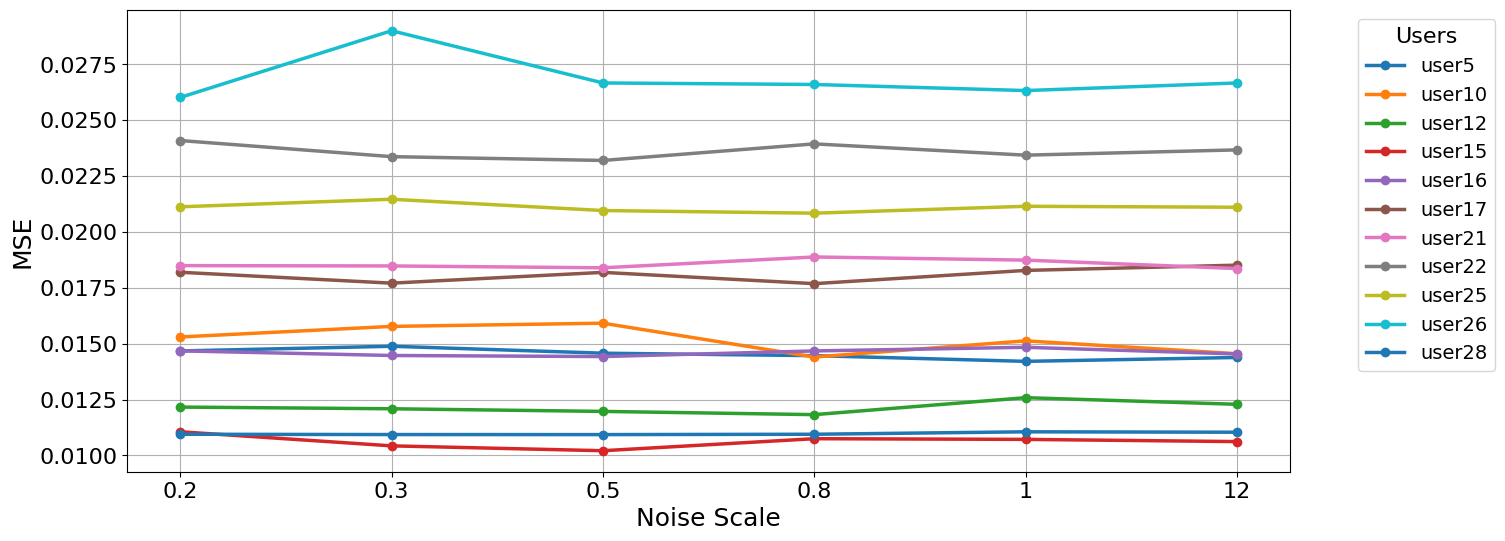

In [32]:
# Load the data
base_dir = os.path.dirname(cwd)
csv_path = os.path.join(base_dir, 'seperate_user_results', 'combined_mse_results_user15_laplace.csv')
df_base = pd.read_csv(csv_path)

# Get the list of users and noise scales from the columns
users = df_base['User'].values
noise_scales = ['0.2', '0.3', '0.5', '0.8', '1', '12']

# Initialize a dictionary to store MSE values for each user across noise scales
mse_per_user = {user: [] for user in users}

# Populate the dictionary with MSE values for each noise scale
for user in users:
    mse_per_user[user] = df_base[df_base['User'] == user].values[0][1:].tolist()

plt.figure(figsize=(15, 6))

# Plot lines for each user using default colors
for user in users:
    plt.plot(noise_scales, mse_per_user[user], label=f'{user}', linestyle='solid', marker='o', linewidth=2.5)

# Increase the font size for x and y axis labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title('Effect of Noise Scale on MSE for Different Users', fontsize=20)
plt.xlabel('Noise Scale', fontsize=18)
plt.ylabel('MSE', fontsize=18)

plt.grid(True)
plt.legend(title='Users', fontsize=14, title_fontsize=16, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()
